In [1]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns # for loading dataset

import matplotlib.pyplot as plt
import matplotlib_inline
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
# import dataset
iris = sns.load_dataset('iris')

# convert pandas to tensor
data = torch.tensor(iris[iris.columns[0:4]].values, dtype=torch.float)

# label encoding
labels = torch.zeros(data.shape[0],dtype=torch.long)

labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

### Brief test using DataLoader

In [3]:
fakeData = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fakeLabels = np.arange(10) > 4

In [4]:
fakeDataLdr = DataLoader(fakeData,shuffle=True)
print(fakeDataLdr)
print(fakeDataLdr.batch_size)

1


In [5]:
for i,oneSample in enumerate(fakeDataLdr):
    print(i,oneSample) # ,oneSample.shape

0 tensor([[31, 32, 33, 34]], dtype=torch.int32)
1 tensor([[51, 52, 53, 54]], dtype=torch.int32)
2 tensor([[101, 102, 103, 104]], dtype=torch.int32)
3 tensor([[91, 92, 93, 94]], dtype=torch.int32)
4 tensor([[61, 62, 63, 64]], dtype=torch.int32)
5 tensor([[71, 72, 73, 74]], dtype=torch.int32)
6 tensor([[81, 82, 83, 84]], dtype=torch.int32)
7 tensor([[21, 22, 23, 24]], dtype=torch.int32)
8 tensor([[41, 42, 43, 44]], dtype=torch.int32)
9 tensor([[11, 12, 13, 14]], dtype=torch.int32)


In [6]:
fakeDataSet = TensorDataset(torch.Tensor(fakeData),torch.Tensor(fakeLabels))
# print(fakeDataSet.tensors)

fakeDataLdr = DataLoader(fakeDataSet,shuffle=True)

for dat,lab in fakeDataLdr:
    print(dat,lab)

tensor([[11., 12., 13., 14.]]) tensor([0.])
tensor([[81., 82., 83., 84.]]) tensor([1.])
tensor([[41., 42., 43., 44.]]) tensor([0.])
tensor([[91., 92., 93., 94.]]) tensor([1.])
tensor([[101., 102., 103., 104.]]) tensor([1.])
tensor([[61., 62., 63., 64.]]) tensor([1.])
tensor([[51., 52., 53., 54.]]) tensor([0.])
tensor([[71., 72., 73., 74.]]) tensor([1.])
tensor([[21., 22., 23., 24.]]) tensor([0.])
tensor([[31., 32., 33., 34.]]) tensor([0.])


In [7]:
train_data,test_data,train_labels,test_labels = train_test_split(fakeData,fakeLabels,test_size=0.2)

train_data = TensorDataset(torch.Tensor(train_data),torch.Tensor(train_labels))

test_data = TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels))

train_loader = DataLoader(train_data,shuffle=True)
test_loader = DataLoader(test_data,shuffle=True)

### Back to real data

In [8]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

train_data = TensorDataset(torch.Tensor(train_data),torch.Tensor(train_labels))

test_data = TensorDataset(torch.Tensor(test_data),torch.Tensor(test_labels))

train_loader = DataLoader(train_data,shuffle=True,batch_size=12)
test_loader = DataLoader(test_data,shuffle=True,batch_size=test_data.tensors[0].shape[0])

In [9]:
for X,y in train_loader:
    print(X.shape,y.shape)

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


In [10]:
def createModel():
    # create the ANN model
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
    )
    
    lossFn = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.01)
    
    return ANNiris, lossFn, optimizer

In [11]:
#global parameter
num_epochs = 500

def trainModel():
    # init vars
    trainAcc = []
    testAcc = []
     
    for epochI in range(num_epochs):
        
        batchAcc = []
        for X,y in train_loader:
            
            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,dim=1)==y).float()).item())
            
        trainAcc.append( np.mean(batchAcc))
        
        X,y = next(iter(test_loader))
        predLabels = torch.argmax(ANNiris(X),dim=1)
        testAcc.append(100*torch.mean((predLabels == y).float()).item())
        
        
        
    return trainAcc,testAcc

In [12]:
ANNiris, lossFn, optimizer = createModel()

trainAcc,testAcc = trainModel()

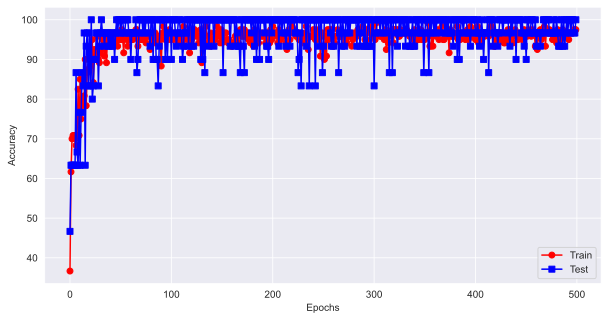

In [13]:
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.show()